In [2]:
import pandas as pd
import numpy as np

In [3]:
SoulG = pd.read_csv("https://media.githubusercontent.com/media/ArunKoundinya/SoulGuard/refs/heads/master/data/Suicide_Detection.csv")


In [4]:
SoulG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [5]:
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
custom_stopwords = {'knew', 'become', 'way', 'put', 'took', 'im', 'etc', 'went', 'got', 'yet',
                    'literally', 'na', 'even', 'gon', 'id', 'wan', 'due', 'instead', 've',
                    't', 'hes', 'ket', 'lot', 'ask', 'many', 'u', 'ni', 'cum', 'basically',
                    'cecil', 'tell', 'stuff', 'use', 'put', 'seem', 'yet', 'yeah', 'done', 'im',
                    'least', 'eve', 'let', 'may', 'actually', 'lol', 'cake', 'give',
                    'ta', 'na', 'give', 'got', 'something', 'like', 'ive', 'ye', 'filler', 'fillerfiller','ampx200b','gtpoplt',
                    'pog', 'penis', 'bacon', 'bruh', 'corn', 'title', 'discochocolate', 'fuck', 'sus', 'gtbyelt', 'as', 'gt', 'lt',
                    'pop', 'amp', 'ampx200b', 'gt', 'jake', 'paul', 'cheese', 'x200b','ur','1','cum', 'brazil'

}
stop_en = set(stopwords.words('english')).union(custom_stopwords)

stop_words = set(stop_en) - { 'not', 'no', 'couldn', "couldn't", "wouldn't", "shouldn't", "isn't",
                                                "aren't", "wasn't", "weren't", "don't", "doesn't", "hadn't", "hasn't",
                                                 "won't", "can't", "mightn't","needn't","nor","shouldn","should've","should",
                                                 "weren","wouldn","mustn't","mustn","didn't","didn","doesn","did","does","hadn",
                                                 "hasn","haven't","haven","needn","shan't"}

lemmatizer = WordNetLemmatizer()

# Function to preprocess the text
def custom_preprocess(text):
    # 1. Remove URLs and replace them with a space
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)

    # 2. Remove emojis
    text = emoji.replace_emoji(text, replace=' ')

    # 3. Replace special characters and punctuation with spaces
    text = re.sub(r'[^A-Za-z0-9\s]+', ' ', text)

    # 4. Remove long binary numbers and meaningless long repetitive characters
    text = re.sub(r'\b[01]{10,}\b', ' ', text)  # Long binary numbers
    text = re.sub(r'(.)\1{5,}', ' ', text)  # Characters repeated more than 5 times

    # 5. Tokenize the text
    tokens = word_tokenize(text.lower())

    # 6. Removing longer token length
    tokens = [token for token in tokens if len(token)<26]
    tokens = [token for token in tokens if len(token)>3]

    # 6. Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # 7. Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token,pos='v') for token in tokens]

    # Join tokens back to a single string
    return ' '.join(tokens)

# Apply the preprocessing function to the dataset
SoulG['cleaned_text'] = SoulG['text'].apply(custom_preprocess)



[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
SoulG.head()

,Unnamed: 0,text,class,cleaned_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,wife threaten suiciderecently leave wife good ...
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird affect compliment come someone know feel...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally 2020 almost never hear 2020 year ever ...
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help cry hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,losthello name adam struggle years afraid past...


In [7]:
## trims trailing and ending spaces
SoulG['cleaned_text'] = SoulG['cleaned_text'].str.strip()

In [8]:
SoulG.head()

,Unnamed: 0,text,class,cleaned_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,wife threaten suiciderecently leave wife good ...
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird affect compliment come someone know feel...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally 2020 almost never hear 2020 year ever ...
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help cry hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,losthello name adam struggle years afraid past...


Generating the Bigrams and Trigrams through functions

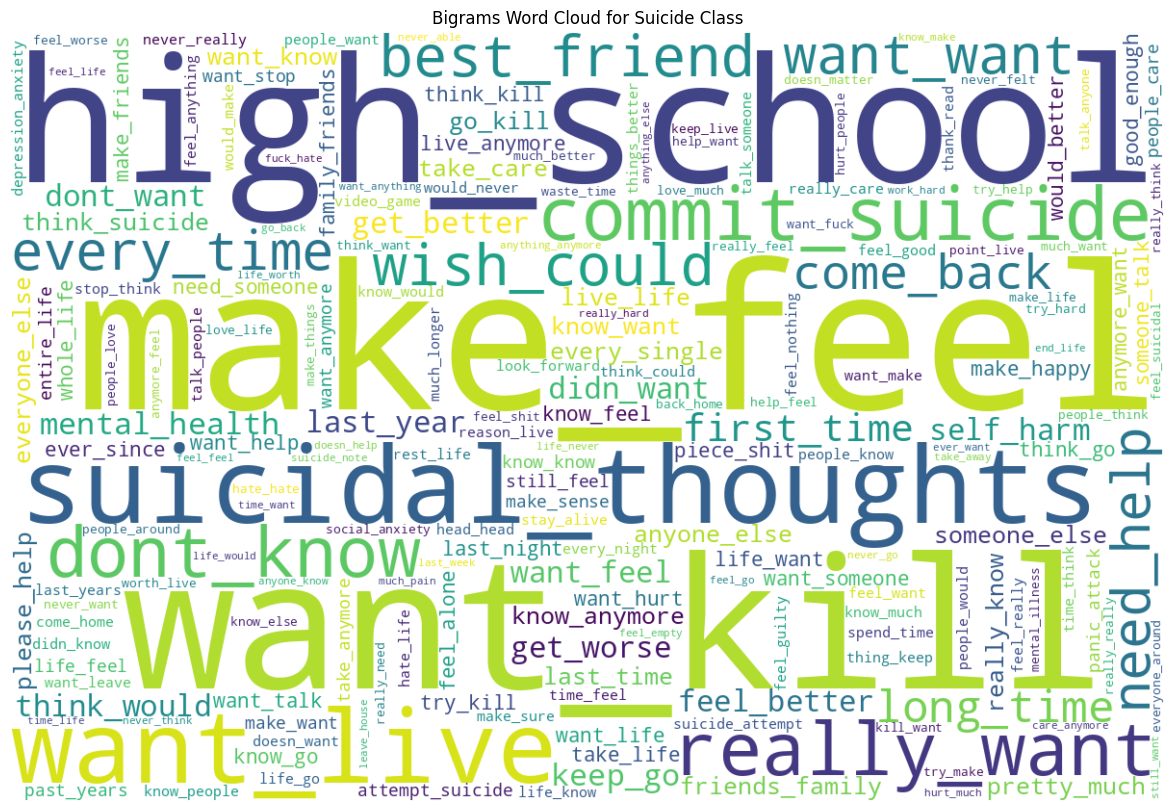

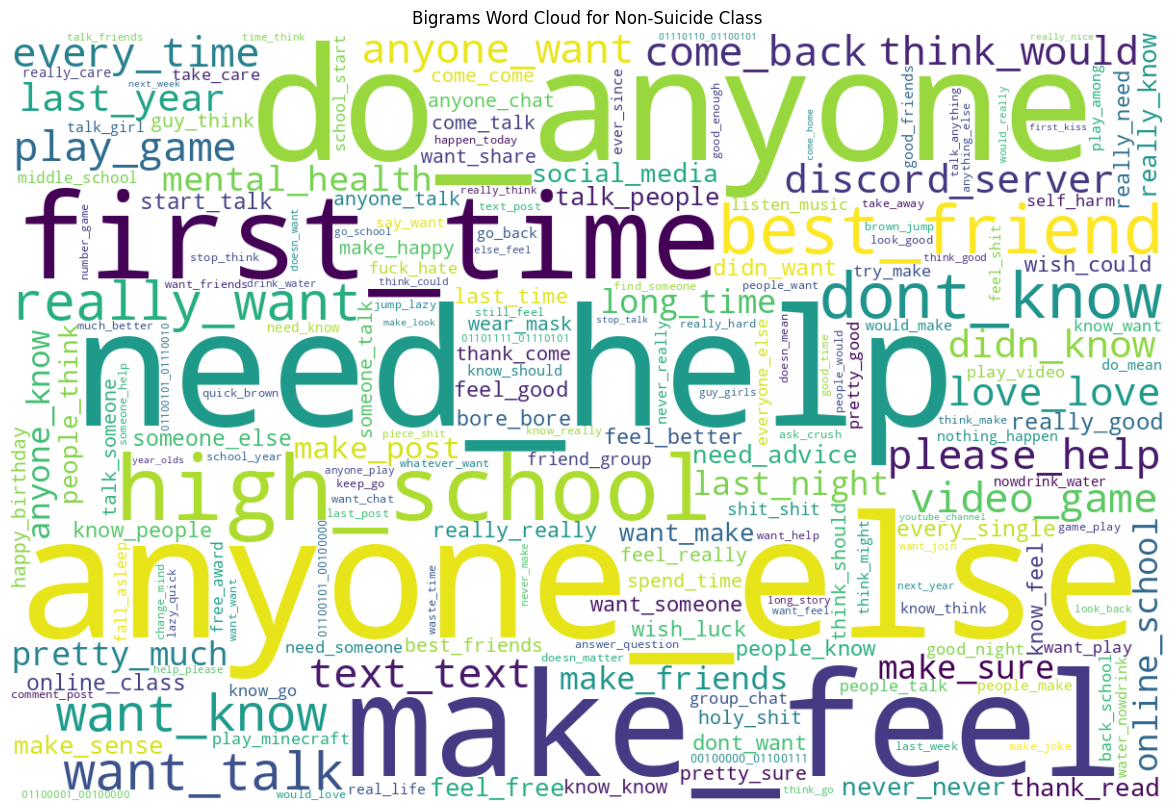

In [9]:
import pandas as pd
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate bigrams from the cleaned_text column
def generate_bigrams(text_series):
    bigrams = []
    for text in text_series:
        tokens = text.split()  # Split text into tokens
        bigrams.extend(ngrams(tokens, 2))  # Generate bigrams
    return bigrams

# Count bigrams
def count_bigrams(bigrams):
    return Counter(bigrams)

# Generate a word cloud for the most common bigrams
def plot_bigram_wordcloud(bigram_counts, title):
    # Prepare data for the word cloud
    bigram_dict = {'_'.join(bigram): count for bigram, count in bigram_counts.items()}
    wordcloud = WordCloud(width=1200, height=800, background_color='white', max_words=200).generate_from_frequencies(bigram_dict)

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Separate the cleaned_text based on class
suicide_texts = SoulG[SoulG['class'] == 'suicide']['cleaned_text']
non_suicide_texts = SoulG[SoulG['class'] == 'non-suicide']['cleaned_text']

# Generate and count bigrams for both classes
suicide_bigrams = generate_bigrams(suicide_texts)
non_suicide_bigrams = generate_bigrams(non_suicide_texts)

suicide_bigram_counts = count_bigrams(suicide_bigrams)
non_suicide_bigram_counts = count_bigrams(non_suicide_bigrams)

# Plot word clouds for both classes
plot_bigram_wordcloud(suicide_bigram_counts, title='Bigrams Word Cloud for Suicide Class')
plot_bigram_wordcloud(non_suicide_bigram_counts, title='Bigrams Word Cloud for Non-Suicide Class')


In [10]:
SoulG['wordlength'] = SoulG['cleaned_text'].apply(lambda x: x.count(' '))+1

In [11]:
SoulG.head()

,Unnamed: 0,text,class,cleaned_text,wordlength
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,wife threaten suiciderecently leave wife good ...,55
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird affect compliment come someone know feel...,11
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally 2020 almost never hear 2020 year ever ...,11
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help cry hard,5
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,losthello name adam struggle years afraid past...,182


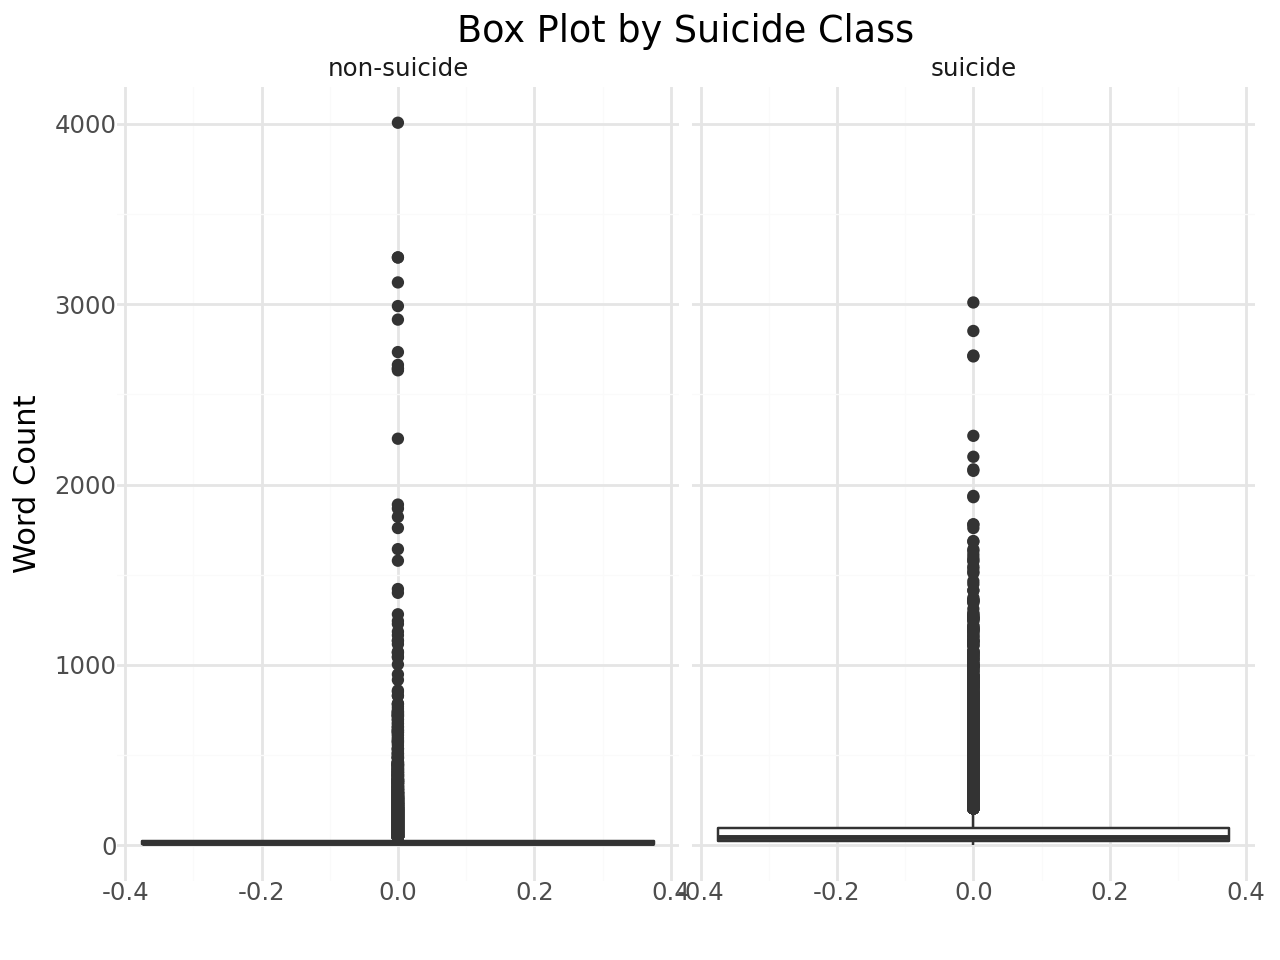

In [12]:
from plotnine import *
(SoulG >>
 ggplot(aes(y='wordlength'))+
 geom_boxplot() +
 facet_wrap('~class') +
 theme_minimal() +
 labs(
     x = " ",
     y = "Word Count",
     title = "Box Plot by Suicide Class"
 )
)

In [13]:
SoulG_Update = SoulG[SoulG['wordlength'] <= 150]

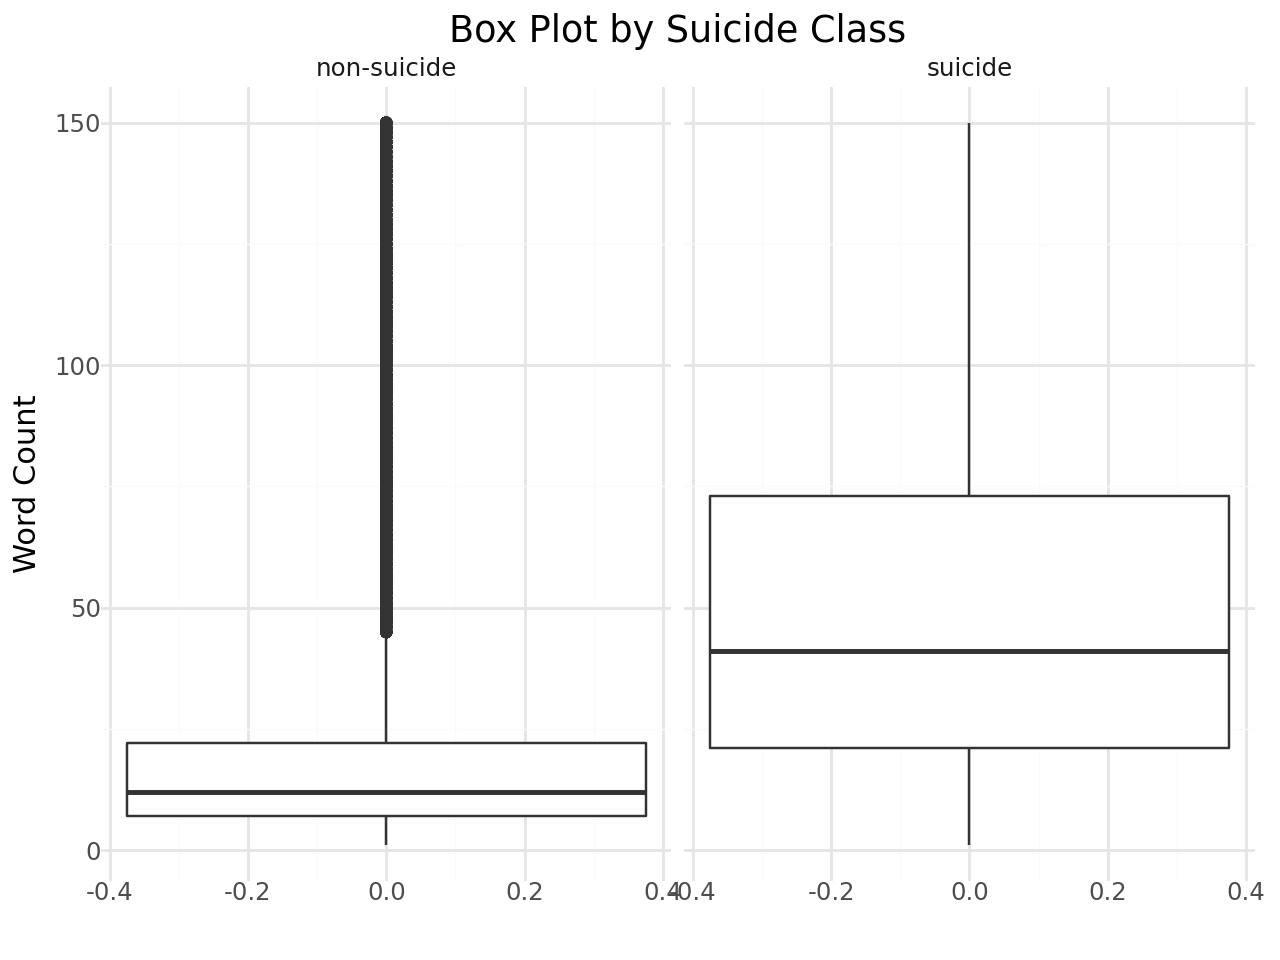

In [14]:
from plotnine import *
(SoulG_Update >>
 ggplot(aes(y='wordlength'))+
 geom_boxplot() +
 facet_wrap('~class') +
 theme_minimal() +
 labs(
     x = " ",
     y = "Word Count",
     title = "Box Plot by Suicide Class"
 )
)

In [15]:
SoulG_Update.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215775 entries, 0 to 232073
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    215775 non-null  int64 
 1   text          215775 non-null  object
 2   class         215775 non-null  object
 3   cleaned_text  215775 non-null  object
 4   wordlength    215775 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 9.9+ MB


In [16]:
SoulG_Update.to_csv('../data/SoulG_Update.csv', index=False)